# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import json
import pickle
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from utils import *
from collections import Counter


os.environ["PYSPARK_PYTHON"] = "/usr/local/bin/python3.5"

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
# conf.setMaster("local[*]")
conf.setAppName("spark_examples")
conf.set("spark.executor.memory", "2g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

conf.set("spark.executor.instances", "2")  # кол-во  executor'ов
conf.set("spark.executor.cores", "2")  # сколько ядер у каждого

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [4]:
!hdfs dfs -copyFromLocal data .

copyFromLocal: `data/.DS_Store': File exists
copyFromLocal: `data/ml-25m/README.txt': File exists
copyFromLocal: `data/ml-25m/genome-scores.csv': File exists
copyFromLocal: `data/ml-25m/genome-tags.csv': File exists
copyFromLocal: `data/ml-25m/links.csv': File exists
copyFromLocal: `data/ml-25m/ml-25m-README.htm': File exists
copyFromLocal: `data/ml-25m/movies.csv': File exists
copyFromLocal: `data/ml-25m/ratings.csv': File exists
copyFromLocal: `data/ml-25m/tags.csv': File exists
copyFromLocal: `data/ml-25m/tmdb.json': File exists


In [5]:
!hdfs dfs -ls data/ml-25m/

Found 10 items
-rw-r--r--   1 root supergroup      10460 2021-02-06 22:34 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2021-02-06 22:34 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2021-02-06 22:34 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2021-02-06 22:34 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2021-02-06 22:34 data/ml-25m/ml-25m-README.htm
drwxr-xr-x   - root supergroup          0 2021-02-07 13:18 data/ml-25m/movie_avg_rating
-rw-r--r--   1 root supergroup    3038099 2021-02-06 22:34 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2021-02-06 22:34 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2021-02-06 22:34 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2021-02-06 22:34 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [6]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')
LINKS_PATH = os.path.join(DATA_PATH, 'links.csv')
TMDB_PATH = os.path.join(DATA_PATH, 'tmdb.json')

In [7]:
ratings = sc.textFile(RATINGS_PATH)

In [8]:
%%time
ratings.take(5)

CPU times: user 6.54 ms, sys: 6.06 ms, total: 12.6 ms
Wall time: 2.54 s


['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [9]:
ratings.getNumPartitions()

5

In [10]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [11]:
ratings.count()

25000095

Количество пользователей

In [12]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 16.1 ms, sys: 6.55 ms, total: 22.7 ms
Wall time: 47.1 s


162541

Сохраним датасет в память

In [13]:
ratings = ratings.persist()

In [14]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 21.7 ms, sys: 7.48 ms, total: 29.2 ms
Wall time: 1min 17s


162541

Количество фильмов

In [15]:
%%time

ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

CPU times: user 15.9 ms, sys: 3.62 ms, total: 19.5 ms
Wall time: 22.9 s


59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [16]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [17]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(180663, (5.0, ['180663', '"Goodbye'])),
 (147966, (5.0, ['147966', "Tarzan's Fight for Life (1958)"])),
 (131628, (5.0, ['131628', 'Loaded (2014)'])),
 (131922, (5.0, ['131922', 'Private Duty Nurses (1971)'])),
 (164787, (5.0, ['164787', 'You Cast A Spell On Me (2015)'])),
 (132321, (5.0, ['132321', 'Black Oak Conspiracy (1977)'])),
 (165221, (5.0, ['165221', 'Elf Bowling the Movie (2007)'])),
 (149268, (5.0, ['149268', 'The Pied Piper (1942)'])),
 (116606, (5.0, ['116606', 'Dark Hearts (2014)'])),
 (198527, (5.0, ['198527', 'Drift (2017)']))]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [19]:
# movie_avg_rating\
#     .repartition(10) \
#     .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [20]:
! hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2021-02-07 13:18 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup      59162 2021-02-07 13:18 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112244 2021-02-07 13:18 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131316 2021-02-07 13:18 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     114299 2021-02-07 13:18 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     133488 2021-02-07 13:18 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     117731 2021-02-07 13:18 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     143222 2021-02-07 13:18 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     132110 2021-02-07 13:18 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     167810 2021-02-07 13:18 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [21]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [22]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [23]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

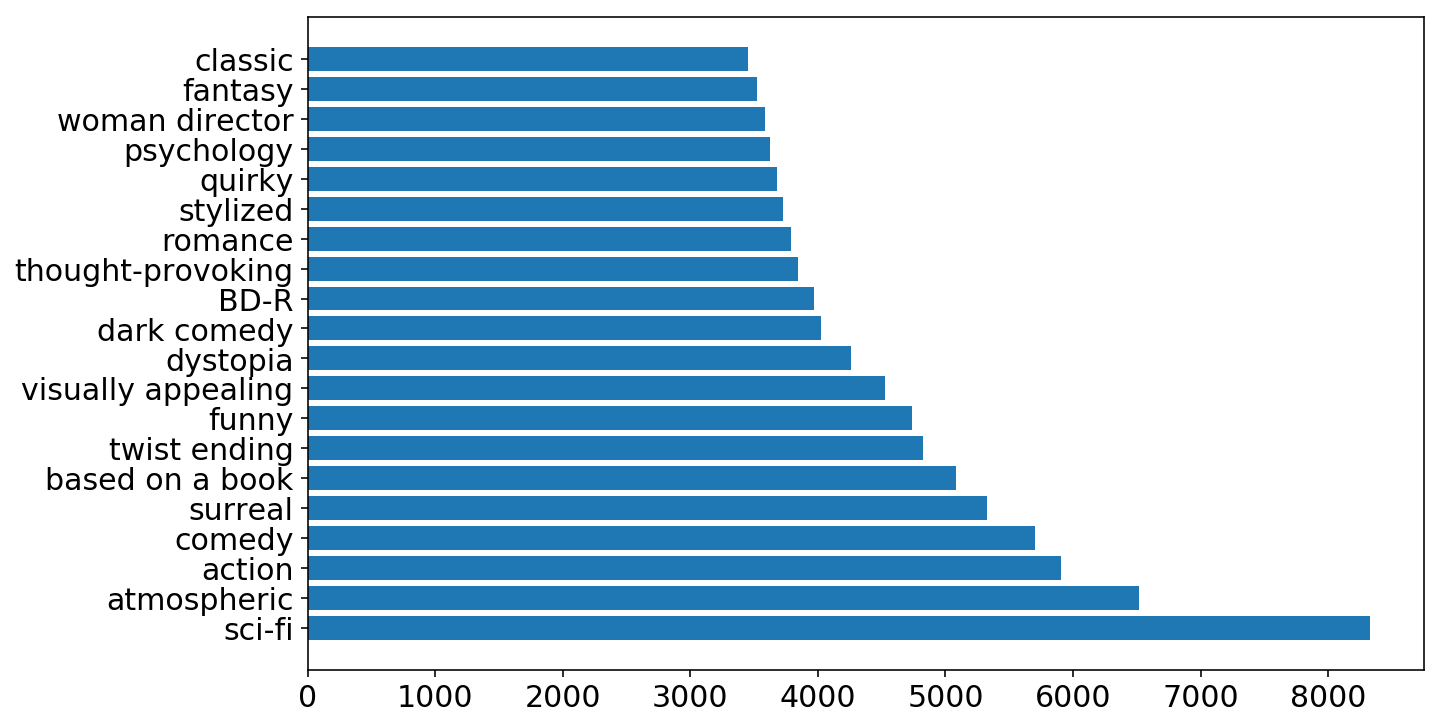

In [24]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=0, fontsize=15)
plt.yticks(fontsize=15)
plt.barh(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [25]:
%%time
movies_ratings = ratings \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b) 

movies_ratings \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False) \
    .map(lambda arr: (arr[1][1][1], arr[1][0])) \
    .take(10)

CPU times: user 40.9 ms, sys: 14.3 ms, total: 55.2 ms
Wall time: 24.5 s


[('Forrest Gump (1994)', 81491),
 ('"Shawshank Redemption', 81482),
 ('Pulp Fiction (1994)', 79672),
 ('"Silence of the Lambs', 74127),
 ('"Matrix', 72674),
 ('Star Wars: Episode IV - A New Hope (1977)', 68717),
 ('Jurassic Park (1993)', 64144),
 ("Schindler's List (1993)", 60411),
 ('Braveheart (1995)', 59184),
 ('Fight Club (1999)', 58773)]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [26]:
%%time
top_movies_5 = ratings \
    .filter(lambda r: r.rating == 5) \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False) \
    .map(lambda ratings: (ratings[1][1][1], ratings[1][0]))

top_movies_5.take(10)

CPU times: user 40.2 ms, sys: 17.8 ms, total: 58 ms
Wall time: 23.2 s


[('"Shawshank Redemption', 39553),
 ('Pulp Fiction (1994)', 32169),
 ('Forrest Gump (1994)', 25918),
 ('Star Wars: Episode IV - A New Hope (1977)', 25804),
 ('"Matrix', 25482),
 ("Schindler's List (1993)", 24853),
 ('"Silence of the Lambs', 24801),
 ('"Godfather', 24418),
 ('"Usual Suspects', 21585),
 ('Fight Club (1999)', 21486)]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

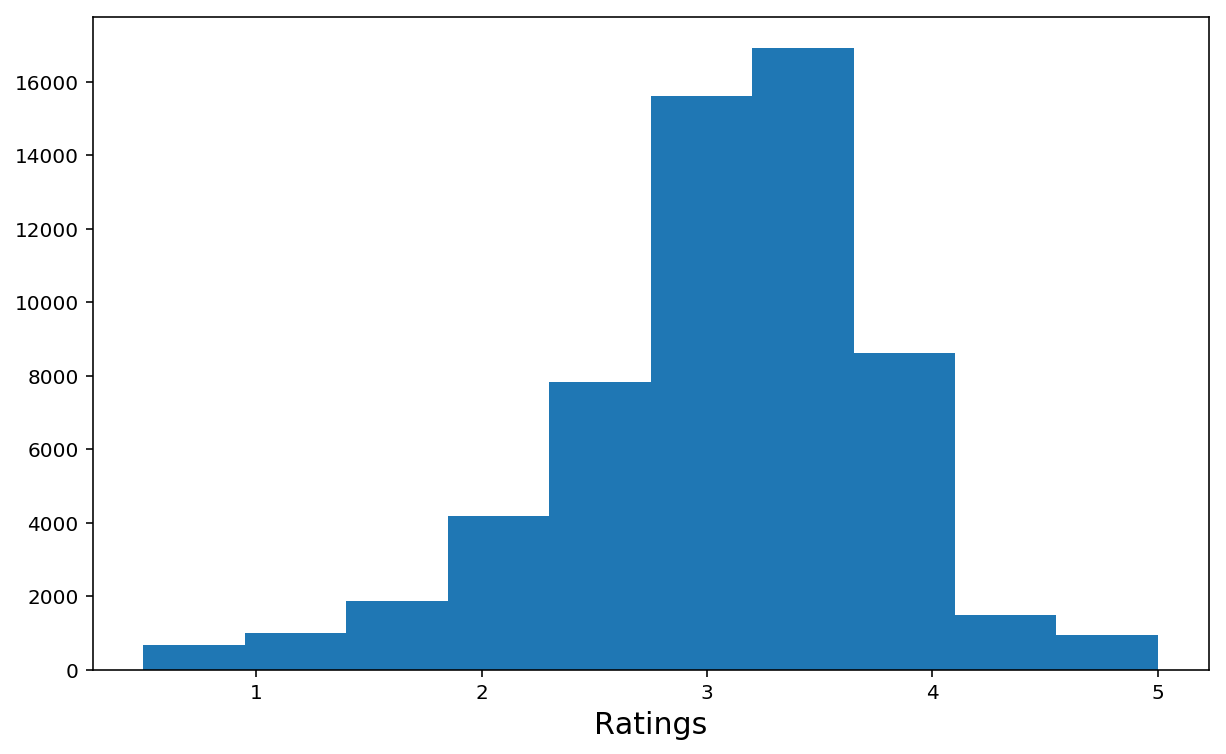

In [27]:
dist_avg = movie_avg_rating.values().collect()

f, ax = plt.subplots(figsize=(10, 6))
plt.hist(dist_avg)
plt.xlabel('Ratings', fontsize=15)
plt.show()

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

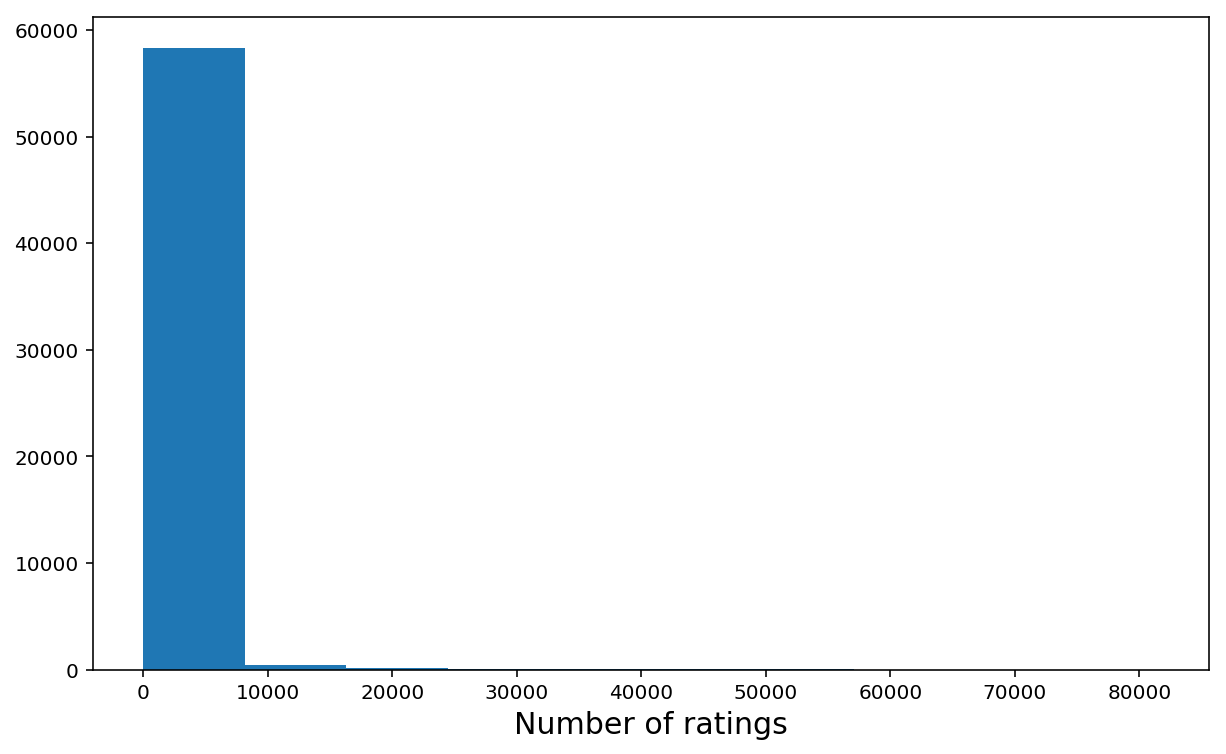

In [28]:
dist_rat = movies_ratings.values().collect()

f, ax = plt.subplots(figsize=(10, 6))
plt.hist(dist_rat)
plt.xlabel('Number of ratings', fontsize=15)
plt.show()

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

In [29]:
movies_info = sc.textFile(MOVIES_PATH)

generes, movies_number = zip(*sorted(movies_info \
                                    .filter(lambda s: 'genres' not in s) \
                                    .flatMap(lambda s: s.split(',')[-1].split('|')) \
                                    .countByValue().items(), key= operator.itemgetter(1)))

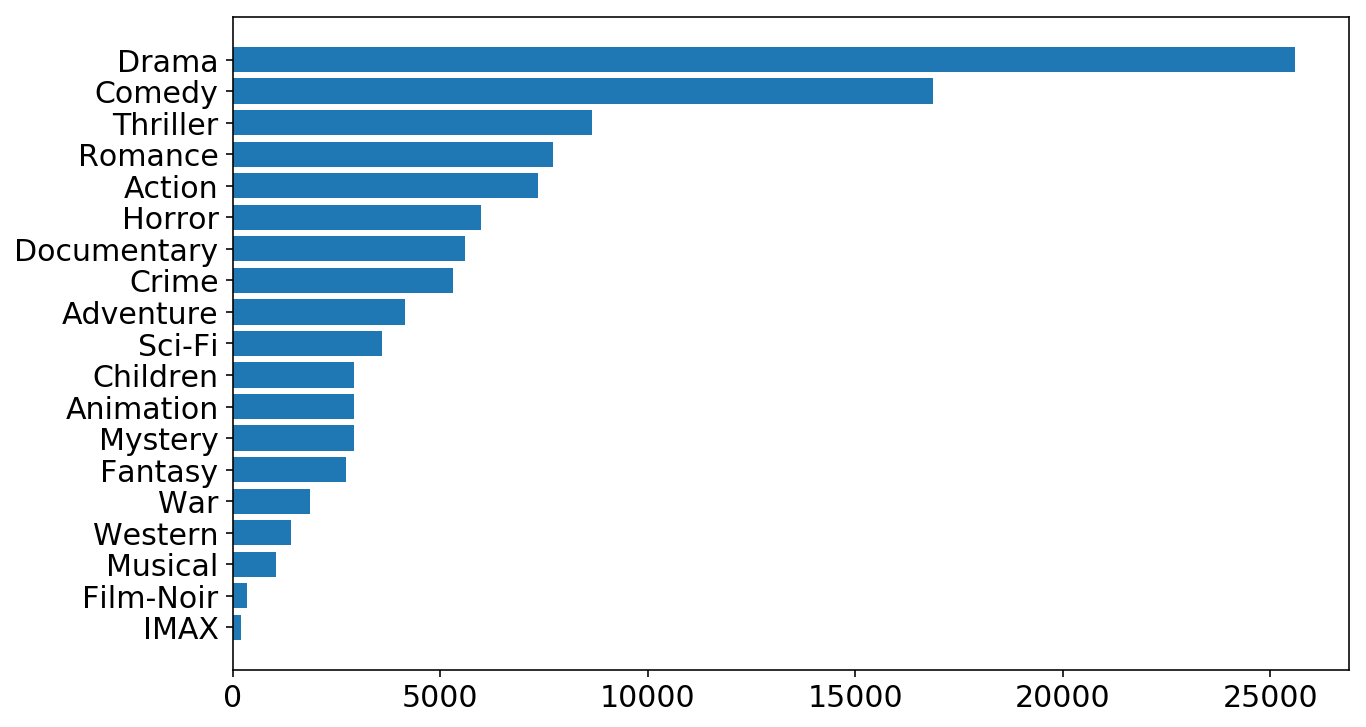

In [30]:
f, ax = plt.subplots(figsize=(10, 6))
plt.yticks(fontsize=15)
plt.xticks(rotation=0, fontsize=15)
plt.barh(generes, movies_number, align="center")
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [31]:
links = sc.textFile(LINKS_PATH)
tmdb = sc.textFile(TMDB_PATH)

In [32]:
actors = tmdb.map(lambda s: json.loads(s)) \
    .filter(lambda d: 'id' in d) \
    .flatMap(lambda d: [(d['id'],
                          (actor['id'], actor['name'])) for actor in d['casts']['cast']]) \

links = sc.textFile(LINKS_PATH)
links = links \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit() and arr[-1].isdigit()) \
    .map(lambda arr: (int(arr[-1]), int(arr[0])))

movies_stat = links \
    .join(actors) \
    .map(lambda arr: (arr[1][0], arr[1][1])) \
    .join(movies) \
    .map(lambda arr: (arr[0], (arr[1][0][0], arr[1][0][1], arr[1][1][1])))

Tom_Hanks = movies_stat \
    .filter(lambda arr: (arr[1][0] == 31 and arr[1][1] == 'Tom Hanks')) \
    .map(lambda arr: arr[1][-1]) \
    .collect()

actor_movies_count = movies_stat \
.map(lambda arr: arr[1][1]) \
.countByValue()

1.

In [33]:
df_Hanks_movies = pd.DataFrame(Tom_Hanks, columns = ['Movie'], index=np.arange(1, len(Tom_Hanks)+1))

df_Hanks_movies

,Movie
1,Sleepless in Seattle (1993)
2,"""Celluloid Closet"
3,Splash (1984)
4,Every Time We Say Goodbye (1986)
5,Elvis Has Left the Building (2004)
6,"""League of Their Own"
7,Captain Phillips (2013)
8,Toy Story of Terror (2013)
9,Shooting War (2000)
10,Killing Lincoln (2013)


2. 

In [34]:
df_actors_top10 = pd.DataFrame(sorted(actor_movies_count.items(), key=operator.itemgetter(1), reverse=True)[:10]
                               , columns = ['Actor', 'Number of movies']
                               , index = np.arange(1, 11))

df_actors_top10

,Actor,Number of movies
1,Bess Flowers,380
2,Frank Welker,184
3,Christopher Lee,175
4,Clarence Nash,158
5,Irving Bacon,152
6,John Carradine,146
7,John Wayne,142
8,Mel Blanc,140
9,Samuel L. Jackson,134
10,Eric Roberts,133


### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [35]:
movie_data = tmdb.map(lambda s: json.loads(s)) \
            .filter(lambda d: ('id' in d) and (type(d['id'])==int) and (d['release_date'][:4].isdigit())) \
            .map(lambda d: (int(d['id']), int(d['release_date'][:4]))) \

movie_data_links = movie_data \
    .join(links) \
    .map(lambda arr: (arr[1][1], arr[1][0]))

idx_genres = movies_info \
    .filter(lambda s: ('genres' not in s) and s.split(',')[0].isdigit()) \
    .map(lambda s: (int(s.split(',')[0]),  s.split(',')[-1].split('|')))

year_genre_count = movie_data_links \
    .join(idx_genres).values() \
    .flatMap(lambda arr: [(arr[0], genre) for genre in arr[1]]) \
    .map(lambda arr: (arr, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .collect()

years, genres = sorted(np.unique([row[0][0] for row in year_genre_count])), \
                sorted(np.unique([row[0][1] for row in year_genre_count]))

genres_count = pd.DataFrame(0, columns=years, index=genres)
for (genre, year), count in year_genre_count:
    genres_count.loc[year, genre] = count

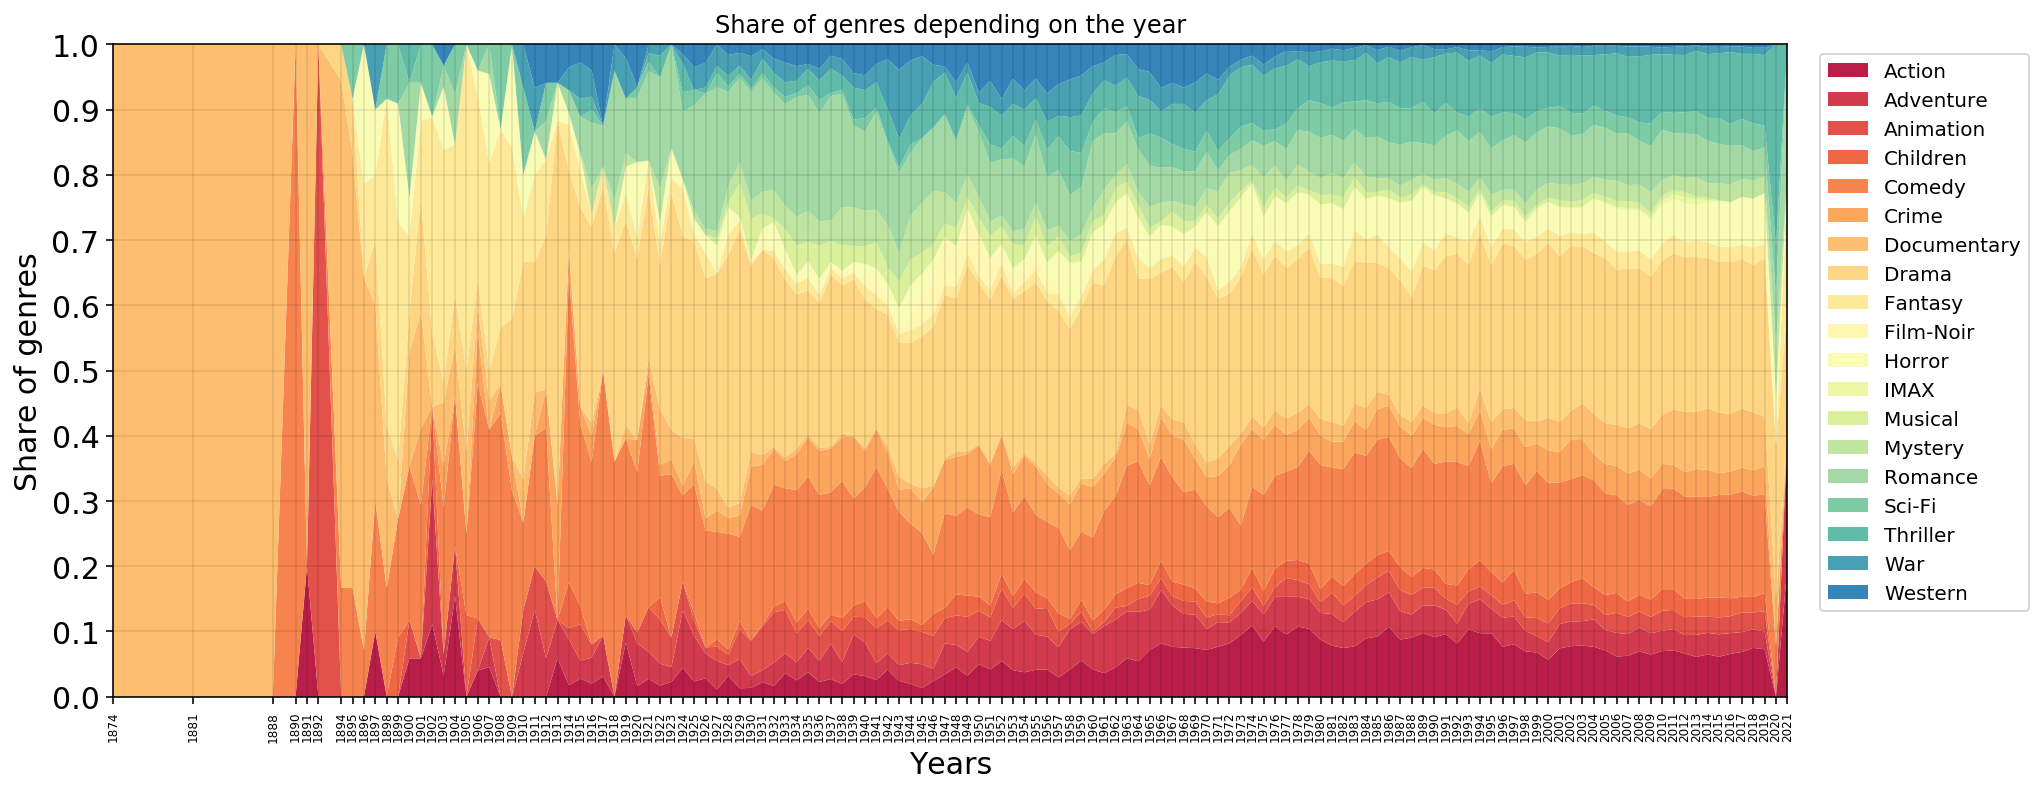

In [37]:
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(ticks = years, rotation=90, fontsize=6)
plt.yticks(fontsize=15)
plt.stackplot(years, genres_count/genres_count.sum(axis=0),
              labels=genres, colors = sns.color_palette("Spectral", 20))
plt.xlim((years[0], years[-1] ))
plt.ylim((0, 1))
plt.title('Share of genres depending on the year')
plt.xlabel('Years', fontsize=15)
plt.ylabel('Share of genres', fontsize=15)
plt.legend(bbox_to_anchor=(1.15, 1))
plt.yticks(np.linspace(0, 1, 11))
plt.grid(color='black', alpha=0.1)
plt.show()

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [40]:
flattred_generes = idx_genres \
.flatMap(lambda arr: [(arr[0], genre) for genre in arr[1]])

movie_data_links = tmdb \
    .map(lambda s: json.loads(s)) \
    .filter(lambda d: ('id' in d) and (type(d['id'])==int)) \
    .map(lambda d: (int(d['id']), (int(d['revenue']), int(d['budget'])))) \
    .join(links) \
    .map(lambda arr: (arr[1][1], arr[1][0]))

generes_revenue_budget = movie_data_links \
    .join(flattred_generes) \
    .map(lambda arr: (arr[1][1], arr[1][0]))

genre_ROI = generes_revenue_budget \
.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
.mapValues(lambda arr: arr[0] / arr[1]) \
.collect()

genre_ROI.sort(key=lambda tup: tup[1], reverse=True)
generes, ROIs = zip(*genre_ROI)

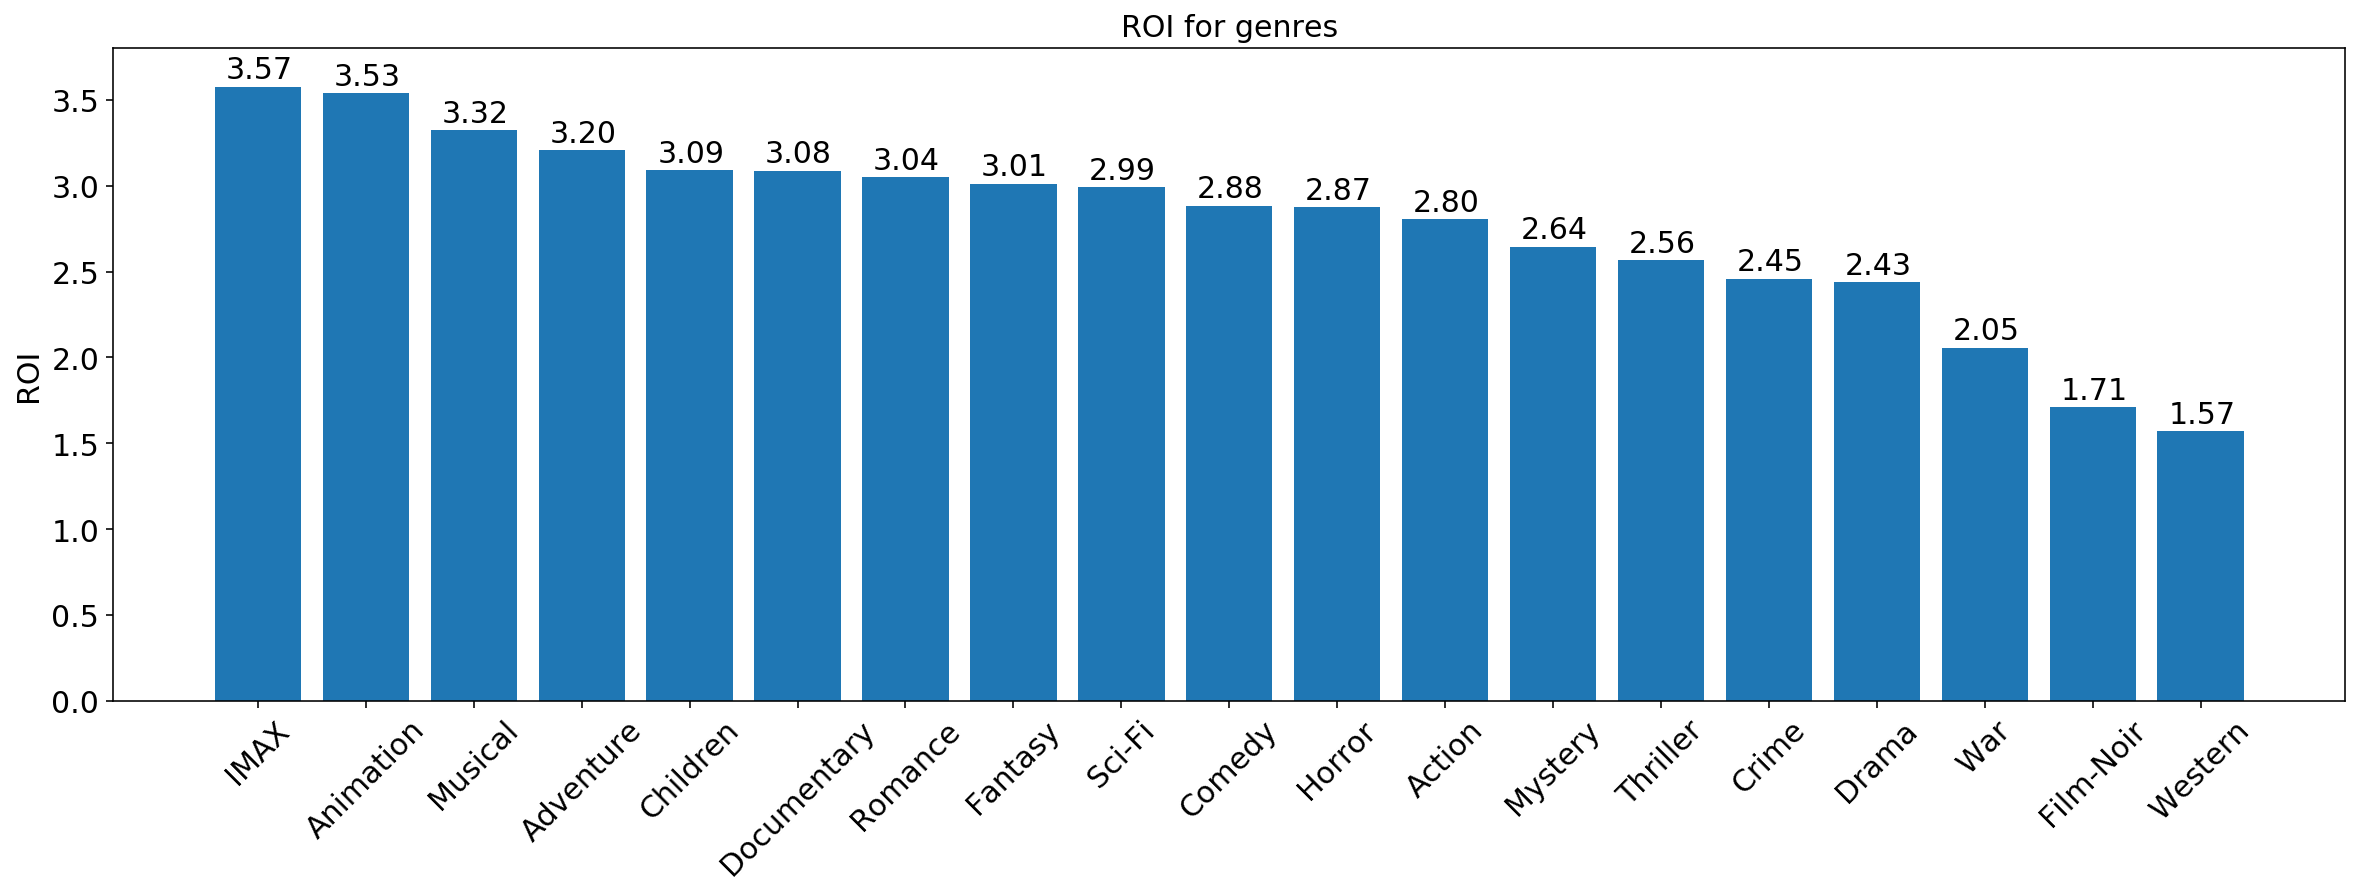

In [41]:
f, ax = plt.subplots(figsize=(20, 6))
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.bar(generes, ROIs, align="center")
plt.title('ROI for genres', fontsize=15)
plt.ylabel('ROI', fontsize=15)
for i, roi in enumerate(ROIs):
    plt.text(i-.3, roi+.05, str(roi)[:4], fontsize=15)
plt.ylim(0, 3.8)
plt.show()